# SME0822 - Análise Multivariada e Aprendizado Não Supervisionado

Francisco Rosa Dias de Miranda - 4402962

Neste trabalho, faremos a análise do conjunto de dados Titanic, publicamente disponível no Kaggle. O objetivo é realizar a análise de componentes principais, k-vizinhos e discriminante linear do conjunto de dados, a fim de agrupar os atributos, identificando fatores importantes e criando regras de classificação para determinar se um indivíduo veio a óbito ou não.

In [1]:
# import data science libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import mlxtend as ml
import missingno as msno

A base de dados obtida possui um conjunto de treino e outro de teste, como o usual em problemas de ciência de dados. Faremos o ajuste do modelo no conjunto de treino

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


## Conjunto de Dados

O Titanic é um conjunto de dados amplamente conhecido que lista os passageiros que estavam a bordo do S.S. Titanic, assim como a informação se eles sobreviveram ou não ao desastre. Geralmente, esse conjunto de dados é utilizado em tarefas de classificação, aqui verificaremos também agrupamentos entre as variáveis.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
chosen_vars = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train = train[chosen_vars]

Escolhemos utilizar um total de 6 variáveis observadas em 891 diferentes indivíduos:

  - `Survived` variável binária que indica se um indivíduo sobreviveu (1) ou não (0) ao naufrágio,
 - `PClass` variável categórica que indica a classe do passageiro (1,2 ou 3)
 - `Sbsp` Quantidade de irmãos / cônjuges a bordo do Titanic
 - `Parch` Quantidade de pais / crianças a bordo do Titanic
 - `Fare` Tarifa paga pelo Passageiro
 - `Embarked` Porto de Embarque (C = Cherbourg, Q = Queenstown, S = Southampton)
 - `Sex` indica o sexo de um indivíduo
 - `Age` indica a idade. Pode ser fracionada se menor que 1.

<AxesSubplot: >

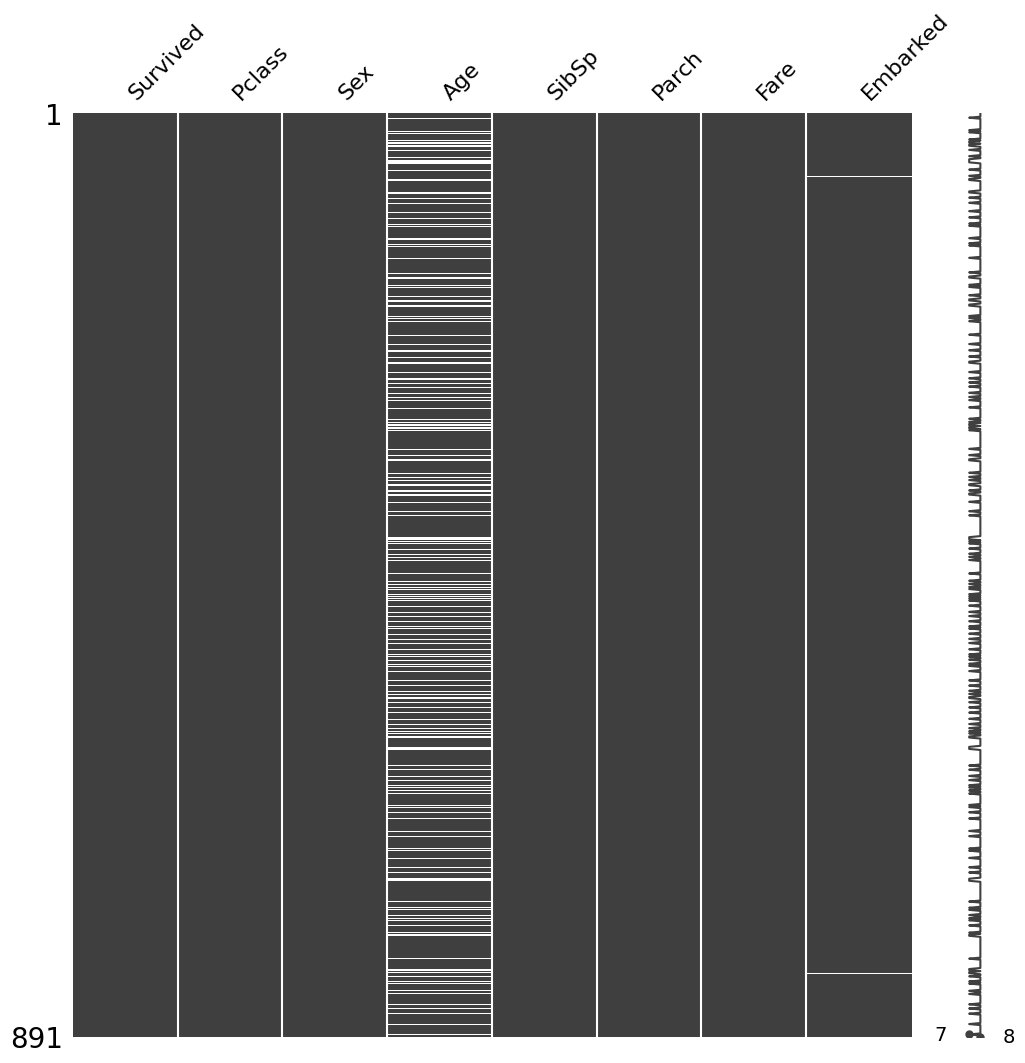

In [6]:
# missing data
msno.matrix(train, figsize=(12,12))

Com auxílio da biblioteca `missingno` verificamos a presença de valores faltantes nas variáveis `Age` e `Embark`. Esses valores poderão ter impacto na saída do ajuste, portanto um curso de ação para os dados faltantes é necessário.

## Preprocessamento

Nossa estratégia para os dados faltantes será substituí-los pela medina, pois ambas as variáveis com dados faltantes são numéricas discretas.

In [7]:
# DEAL WITH NANs

#inputing nan in Age
train['Age'].fillna(train['Age'].median(), inplace=True)

#inputing nan in Fare
train['Fare'].fillna(train['Fare'].median(), inplace=True)

Após o inputing dos dados faltantes, vamos transformar as variáveis categóricas em binárias, criando novas colunas para as novas categorias em nosso conjunto de dados.

In [8]:
# TRAIN
# dummy variables for embarked, pclass and sex  
embarked = pd.get_dummies(train['Embarked'], drop_first=True)
pclass = pd.get_dummies(train['Pclass'], drop_first=True)
sex = pd.get_dummies(train['Sex'], drop_first=True)

# select features
features = ['Age', 'SibSp', 'Parch', 'Fare']


# combine the dummy variables
X = pd.concat([train[features], embarked, pclass, sex], axis=1)
y = train['Survived']


In [9]:
X

,Age,SibSp,Parch,Fare,Q,S,2,3,male
0,22.0,1,0,7.2500,0,1,0,1,1
1,38.0,1,0,71.2833,0,0,0,0,0
2,26.0,0,0,7.9250,0,1,0,1,0
3,35.0,1,0,53.1000,0,1,0,0,0
4,35.0,0,0,8.0500,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0,1,1,0,1
887,19.0,0,0,30.0000,0,1,0,0,0
888,28.0,1,2,23.4500,0,1,0,1,0
889,26.0,0,0,30.0000,0,0,0,0,1


In [10]:
# TEST
# dummy variables for embarked, pclass and sex  
embarked = pd.get_dummies(train['Embarked'], drop_first=True)
pclass = pd.get_dummies(train['Pclass'], drop_first=True)
sex = pd.get_dummies(train['Sex'], drop_first=True)

# combine the dummy variables
test = pd.concat([train[features], embarked, pclass, sex], axis=1)

## Análise Exploratória

Iniciamos a exploração dos dados com o auxílio de gráficos de barra de todas as variáveis escolhidas nas etapas anteriores.

array([[<AxesSubplot: title={'center': 'Survived'}>,
        <AxesSubplot: title={'center': 'Pclass'}>],
       [<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'SibSp'}>],
       [<AxesSubplot: title={'center': 'Parch'}>,
        <AxesSubplot: title={'center': 'Fare'}>]], dtype=object)

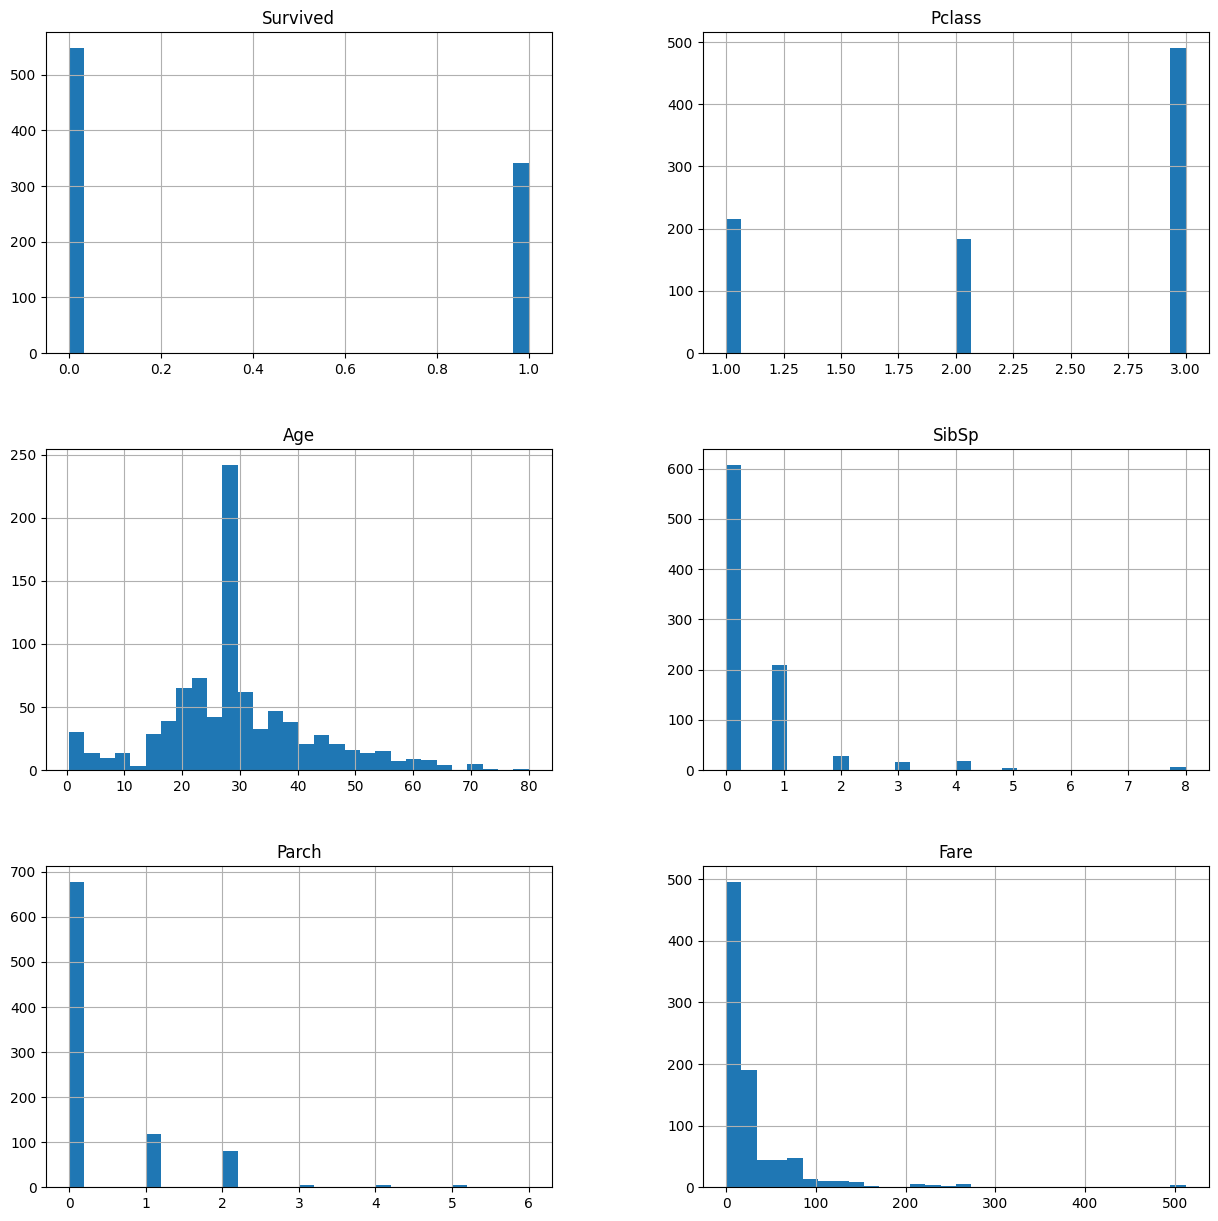

In [11]:
# barplots for numeric data
train.hist(figsize=(15,15), bins = 30)
           

In [12]:
# explore data
X.describe()

,Age,SibSp,Parch,Fare,Q,S,2,3,male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.361582,0.523008,0.381594,32.204208,0.086420,0.722783,0.206510,0.551066,0.647587
std,13.019697,1.102743,0.806057,49.693429,0.281141,0.447876,0.405028,0.497665,0.477990
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,1.000000,1.000000
75%,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


Algumas considerações a respeito dos gráficos de barra:
 - A maioria dos passageiros (mais de 60%) não sobreviveu ao incidente
 - A maioria das pessoas é da terceira classe
 - A idade possui uma distribuição aparentemente assimétrica
 - 64% dos passageiros são do sexo masculino

<AxesSubplot: >

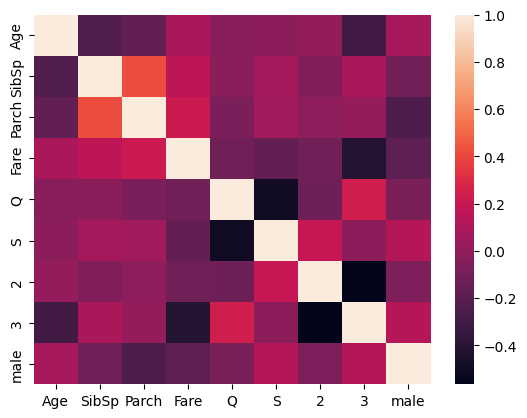

In [13]:
# variable correlation
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
            

Através do correlograma acima notamos uma alta correlação entre a classe e o preço da passagem, o que era esperado devido ao preço ser dependente da classe.

## Modelagem

### Parte 1: Análise de Componentes Principais 

A primeira etapa de nossa análise consiste em encontrar as componentes principais, a fim de reduzirmos a dimensionalidade e interpretar as combinações lineares

In [21]:
# PCA libs
from sklearn.decomposition import PCA

# transform all feature names in strings
X.columns = X.columns.astype(str)

pca = PCA(n_components=7)
fit = pca.fit_transform(X)


<AxesSubplot: >

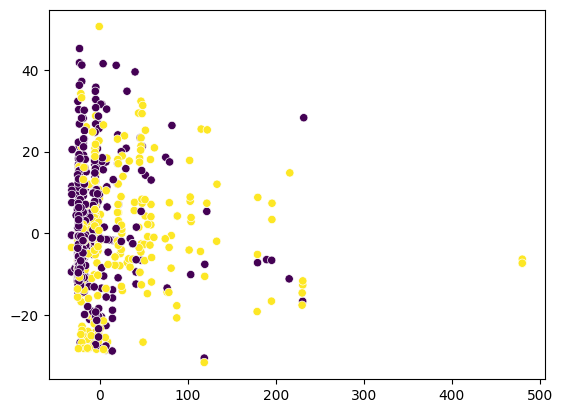

In [22]:
sns.scatterplot(x = fit[:,0], y= fit[:,1], c = y)

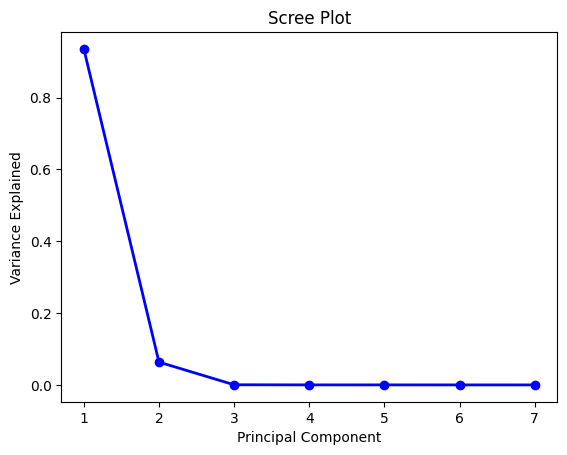

In [23]:

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [24]:
print(pca.explained_variance_ratio_)

[9.35467281e-01 6.35690502e-02 4.73920386e-04 1.79419974e-04
 1.20168050e-04 9.07059561e-05 6.20324979e-05]


In [26]:
pca.explained_variance_

array([2.47125660e+03, 1.67932581e+02, 1.25197204e+00, 4.73980015e-01,
       3.17452137e-01, 2.39621093e-01, 1.63873417e-01])

Aqui temos que uma única componente principal foi responsável por explicar 93,5% da fonte de variabilidade total dos dados.

### Parte 2: Análise discriminante

A LDA é um algoritmo de classificação que utiliza medidas descritivas dos grupos para determinar uma regra de decisão. ELa assume que os atributos são igualmente dispersos e normalmente distribuídos, assim como que os preditores são linearmente não correlacionados.

Em contraste com o PCA, o LDA é um método de aprendizado supervisionado, utilizando rótulos conhecidos no conjunto de treino.

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mlxtend.plotting import plot_decision_regions

In [55]:
# lda
clf1 = LDA()
clf2 = sk.neighbors.KNeighborsClassifier()
lda_fit = clf.fit_transform(X, y)


In [52]:
clf.coef_

array([[-4.02676853e-02, -2.88296941e-01, -1.11366403e-01,
         2.45962952e-03, -4.48155519e-02, -4.85419737e-01,
        -1.00264213e+00, -2.34782621e+00, -3.52885200e+00]])

In [58]:
from sklearn.preprocessing import StandardScaler
# Chosing axes for decision regions
X_t = sk.preprocessing.StandardScaler().fit_transform(X[['Fare', 'Age']])


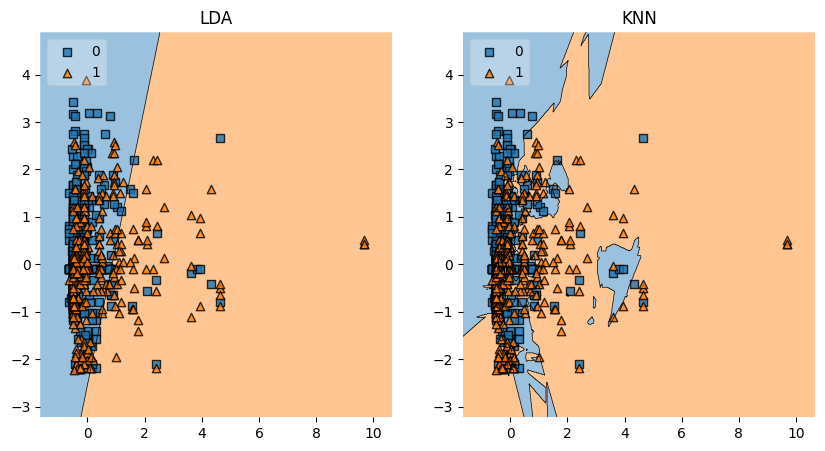

In [59]:
import itertools
# Plotting decision regions

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(10, 5))

labels = ['LDA', 'KNN']


for clf, lab, grd in zip([clf1, clf2], labels,
                         itertools.product([0, 1],
                         repeat=2)):

    clf.fit(X_t, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_t, y=np.array(y), clf=clf, legend=2)
    plt.title(lab)

plt.show()

## Referências

 - Ciência de Dados. Francisco Aparecido Rodrigues. https://github.com/franciscoicmc/ciencia-de-dados
 - PyCaret.org. PyCaret, April 2020. URL https://pycaret.org/about. PyCaret version 1.0.0.
 - Raschka, Sebastian (2018) MLxtend: Providing machine learning and data science utilities and extensions to Python's scientific computing stack. J Open Source Softw 3(24).
